STEP - 1 : IMPORT THE REQUIRED LIBRARIES

In [169]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math

from statsmodels.tsa.stattools import adfuller

STEP - 2 : LOAD THE DATA

In [170]:
file_path = r"C:\Users\titik\OneDrive\Desktop\Data Science\Analytics Capstone Project\amz_uk_processed_data.csv"
data = pd.read_csv(file_path)
data.head(1)

,asin,title,imgUrl,productURL,stars,reviews,price,isBestSeller,boughtInLastMonth,categoryName
0,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",https://m.media-amazon.com/images/I/71C3lbbeLs...,https://www.amazon.co.uk/dp/B09B96TG33,4.7,15308,21.99,False,0,Hi-Fi Speakers


In [171]:
data.shape # Rows and Columns of dataset respectively

(2222742, 10)

STEP - 3 : DATA PREPARATION

3.1. FEATURE ENGINEERING

(I) DROP UNREQUIRED FEATURES AND RENAME THE REQUIRED ONES

In [172]:
# (A) Drop The Unrequired Columns From The Dataframe
data = data.drop(['asin','imgUrl', 'productURL', 'boughtInLastMonth'], axis = 1)

In [173]:
# (B) Rename The Columns Names
data = data.rename(columns = {'title' : 'Product Name', 'stars' : 'Stars', 'reviews' : 'Reviews', 'price' : 'Price', 
                              'isBestSeller' : 'IsBestSeller', 'categoryName' : 'CategoryName'})

(II) ADD FEATURES REQUIRED FOR DEVELOPING ML MODELS

In [174]:
# (A) Extract Brand Name using str.split()
data['Brand Name'] = data['Product Name'].str.split('|').str[0].str.split().str[0]

In [175]:
# (B) Compute Brand Strength
# 0 = unfamous brand, 1 = famous brand
data['Brand Strength'] = data['IsBestSeller'].astype(int)

In [176]:
# (C) Compute Competitor Price : by computing average price of Price feature for each CategoryName
# Approximate competitor price for each category of the product 
data['Competitor Price'] = data.groupby('CategoryName')['Price'].transform('mean')

In [177]:
# (G) Compute Popularity Score
# Approximate popularity score for each product (multiply stars with reviews)
data['Popularity Score'] = data['Stars']*data['Reviews']

In [178]:
# (H) Compute Price Elasticity
# Lower the price elasticity, price change won't lose sales (i.e., product is more popular and can handle price change)
data['Price Elasticity'] = data['Price']/(data['Popularity Score'])

In [179]:
# (I) Compute Inventory Turnover Rate
# Higher ITR : Fast Moving Products while Lower ITR : Potential Overstock
data['Inventory Turnover Rate'] = data['Reviews']/data['Price']

In [180]:
# (J) Compute Category Level Market Share
# Higher the market share, higher the dominance in that particular category
data['Market Share'] = data['Reviews'] / data.groupby('CategoryName')['Reviews'].transform('sum')

Important Features : 

1. Price Elasticity, Competitor Price Comparison, Sale Growth : gives in depth details of product sales
2. Inventory Turnover Rate : gives in depth details of stock inventory

(III) ADD FEATURES REQUIRED FOR ARIMA MODEL

In [181]:
#Given the information, data has been scrapped in October 2023

np.random.seed(42) 

# (A) Compute the Year And Month {random} package
data['Year'] = np.random.choice([2023], size=len(data))

data['Month'] = np.random.randint(10, 13, size=len(data))
# 'Month' for passing in Time Series and ML models

In [182]:
# (B) Moving Average For Price
# Short Term MA
data['MA_50_Price'] = data['Price'].rolling(window = 50, min_periods = 1).mean()
# Long Term MA
data['MA_200_Price'] = data['Price'].rolling(window = 200, min_periods = 1).mean()

In [183]:
# (D) MA Signals Bullish / Berrish
# If Short Term MA > Long Term MA meaning prices rising in Short Term as compared to Long Term thus Bullish signal else Berrish
data['Bullish/Berrish_Price'] = np.where(data['MA_50_Price'] > data['MA_200_Price'], 'Bullish', 'Berrish')

3.2. CLEAN THE DATA

(I) DROP NaN and inf Values FROM THE DATASET

In [184]:
data = data.dropna()

(II) DROP UNNECESARY FEATURES SINCE FEATURE ENGINEERING IS COMPLETE AND NOT MORE NEEDED

In [185]:
data = data.drop(['Stars', 'Reviews', 'IsBestSeller', 'Brand Strength'], axis=1)

STEP - 4 : PERFORM EXPLORATORY DATA ANALYSIS

4.1. UNDERSTAND THE DATA

In [186]:
data.head(1) # Get the first row of dataset

,Product Name,Price,CategoryName,Brand Name,Competitor Price,Popularity Score,Price Elasticity,Inventory Turnover Rate,Market Share,Year,Month,MA_50_Price,MA_200_Price,Bullish/Berrish_Price
0,"Echo Dot (5th generation, 2022 release) | Big ...",21.99,Hi-Fi Speakers,Echo,129.97202,71947.6,0.000306,696.134607,0.002371,2023,12,21.99,21.99,Berrish


In [187]:
data.tail(1) # Get the last row of dataset

,Product Name,Price,CategoryName,Brand Name,Competitor Price,Popularity Score,Price Elasticity,Inventory Turnover Rate,Market Share,Year,Month,MA_50_Price,MA_200_Price,Bullish/Berrish_Price
2222741,RIDEX CJ223 Motorcycle Motorbike Jacket Armour...,53.99,Motorbike Clothing,RIDEX,45.612624,153.0,0.352876,0.629746,0.000196,2023,12,61.1414,44.1134,Bullish


In [188]:
data.shape # Rows and Columns of dataset respectively

(2222607, 14)

In [189]:
data.dtypes # Datatypes of the features within dataset

Product Name                object
Price                      float64
CategoryName                object
Brand Name                  object
Competitor Price           float64
Popularity Score           float64
Price Elasticity           float64
Inventory Turnover Rate    float64
Market Share               float64
Year                         int32
Month                        int32
MA_50_Price                float64
MA_200_Price               float64
Bullish/Berrish_Price       object
dtype: object

----- UNDERSTANDING FEATURES OF DATASET -----

(A) ALREADY EXISTING FEATURES

1. Product Name : this feature has the name of the product
2. CategoryName : this feature contains the category name of the product
tor Price
3. Price : this feature has price of the product

(B) FEATURES ADDED IN FEATURE ENGINEERING

1. Brand Name : this feature has the brand name of the product
2. Competitor Price : this feature has the computed competitor price of the product
4. Popularty Score : this feature gives information of how popular the product is
5. Price Elasticity : this feature gives information of if and how the price change affects the sales of product
6. Inventory Turnover Rate : this feature gives information of if the product lies in category of FMG or potential overstock
8. Market Share : this feature tells the dominance of category of product in market
9. Year : this feature tells the year of the product was sold
10. Month : this feature tells the month of the product was sold in numeric
11. MA_50_Price : this feature contains the moving average of price within 50 rolling window
12. MA_200_Price : this feature contains the moving average of price within 200 rolling window
13. Bullish/Berrish_Price : this feature gives if fluctuation is positive (Bullish) or negative (Berrish) for price

In [190]:
data.isna().sum() # If any null values within dataset

Product Name               0
Price                      0
CategoryName               0
Brand Name                 0
Competitor Price           0
Popularity Score           0
Price Elasticity           0
Inventory Turnover Rate    0
Market Share               0
Year                       0
Month                      0
MA_50_Price                0
MA_200_Price               0
Bullish/Berrish_Price      0
dtype: int64

4.2. DESIGN VISUALIZATIONS

(I) PRICE TREND WITH MOVING AVERAGES

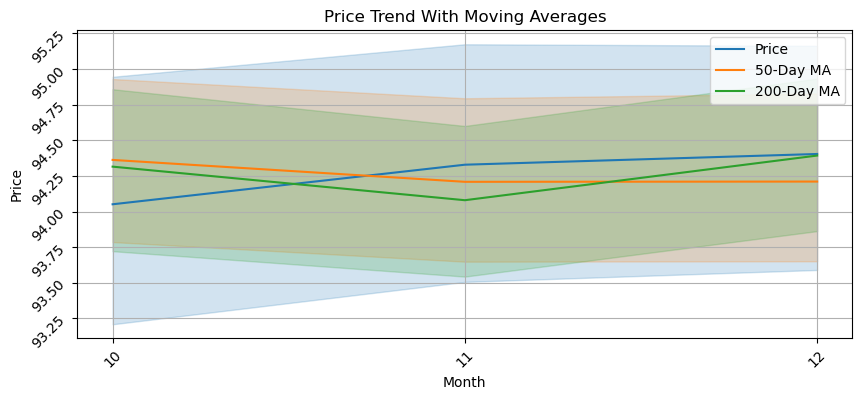

In [191]:
plt.figure(figsize=(10, 4))
sns.lineplot(x='Month', y='Price', data=data, label='Price')
sns.lineplot(x='Month', y='MA_50_Price', data=data, label='50-Day MA')
sns.lineplot(x='Month', y='MA_200_Price', data=data, label='200-Day MA')
plt.title("Price Trend With Moving Averages")
plt.xlabel("Month")
plt.ylabel("Price")
plt.xticks(ticks=[10, 11, 12], rotation = 45)
plt.yticks(rotation = 45)
plt.legend()
plt.grid()
plt.show()

Insights Drawn :

1. October saw lower than usual price compared to 50-Day MA and 200-Day MA that suggests a possible period of price reduction
2. November had a bullish phase of price, meaning the possibility of potentially higher demand of products or price adjustments
3. December had a slight bullish phase of price, meaning possibility of slightly higher demand of products or price adjustments but need to be monitored since it was in slight bullish phase
   
Conclusion :

The overall Price trend suggest need of strategical pricing in order to improvise revenue and profitability

(II) CORRELATION BETWEEN PRICE AND PRICE ELASTICITY

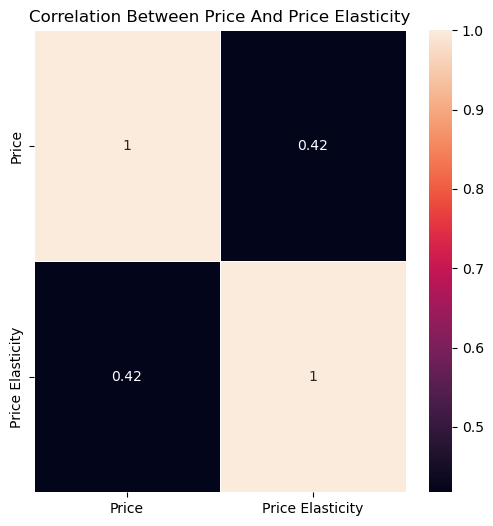

In [192]:
corr_matrix = data[['Price', 'Price Elasticity']].corr()

plt.figure(figsize=(6, 6))
sns.heatmap(corr_matrix, annot=True, linewidths=0.5)
plt.title("Correlation Between Price And Price Elasticity")
plt.show()

Insights Drawn :
1. There is potentially good correlation between Price and Price Elasticity features (42%), meaningly there are chances of increase in profit
2. If Price Elasticity is less as compared to Price then product can handle the price change

Conclusion : 

The particular product whose Price Elasticity is lower can help in increasing slight sales thus leading to increase in slight profit 

(III) PRICE V/S COMPETITOR PRICE COMPARISON

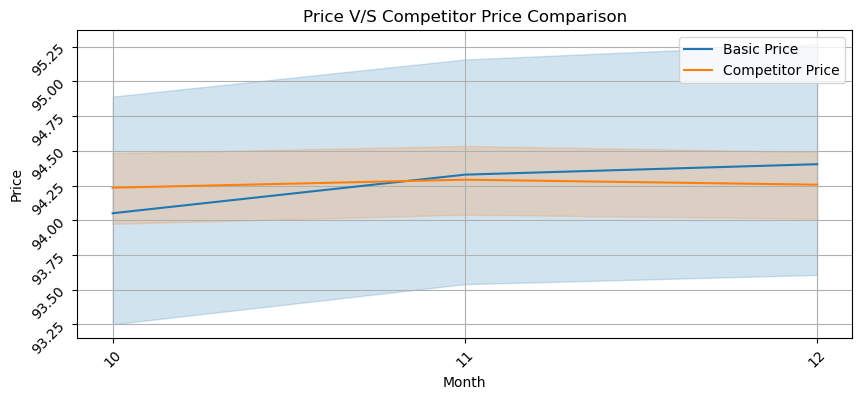

In [193]:
plt.figure(figsize=(10, 4))
sns.lineplot(x='Month', y='Price', data=data, label='Basic Price')
sns.lineplot(x='Month', y='Competitor Price', data=data, label='Competitor Price')
plt.title("Price V/S Competitor Price Comparison")
plt.xlabel("Month")
plt.ylabel("Price")
plt.xticks(ticks=[10, 11, 12], rotation = 45)
plt.yticks(rotation = 45)
plt.legend()
plt.grid()
plt.show()

Insights Drawn : 

1. The Basic Price was less in October so there is slight increase in Basic Price around November and potentially slight more Basic Price increase in December
2. The Competitor Price was more in October then there is slight increase in Competitor Price around November and slight Competitor Price decrease in December
   
Conclusion :

The basic price trend indicates that there is slight growth in market strength and pricing power of the products throughout from October to December

(IV) POPULARITY SCORE, MARKET SHARE AND INVENTORY TURNOVER RATE VISUALIZATION BY PRICE

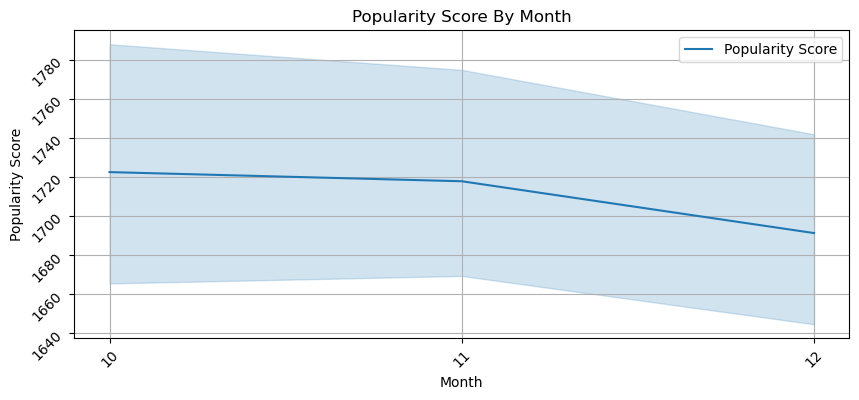

In [194]:
plt.figure(figsize=(10, 4))
sns.lineplot(x='Month', y='Popularity Score', data=data, label='Popularity Score')
plt.title("Popularity Score By Month")
plt.xlabel("Month")
plt.ylabel("Popularity Score")
plt.xticks(ticks = [10, 11, 12], rotation=45)
plt.yticks(rotation=45)
plt.grid()
plt.show()

Insights Drawn : 

1. There is a slight reduction in Popularity Score in November month
2. There is more drop of Popularity Score in December month
3. So there is overall reduction of Popularity Score throughout October to December

Conclusion : 

The gradual decline in Popularity Score from October to December suggests that consumer interest in products decreased over last few months of the year. 

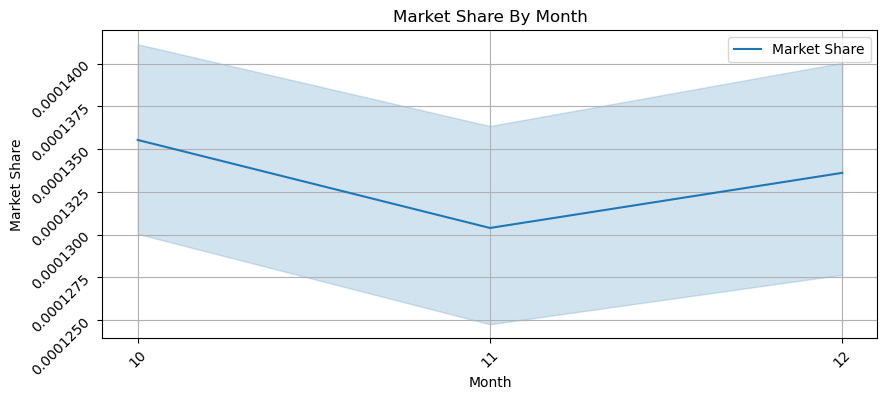

In [195]:
plt.figure(figsize=(10, 4))
sns.lineplot(x='Month', y='Market Share', data=data, label='Market Share')
plt.title("Market Share By Month")
plt.xlabel("Month")
plt.ylabel("Market Share")
plt.xticks(ticks = [10, 11, 12], rotation=45)
plt.yticks(rotation=45)
plt.grid()
plt.show()

Insights Drawn : 

1. There was sudden drop of Market Share in November month
2. Then there was slight increase of Market Share in December month

Conclusion : 

1. The overall Market Share trend suggests that though there was drop in November, there was still slight recovery phase but not strong in December.
2. This suggests the need for ongoing market analysis and strategic price adjustments to ensure sustainable market growth

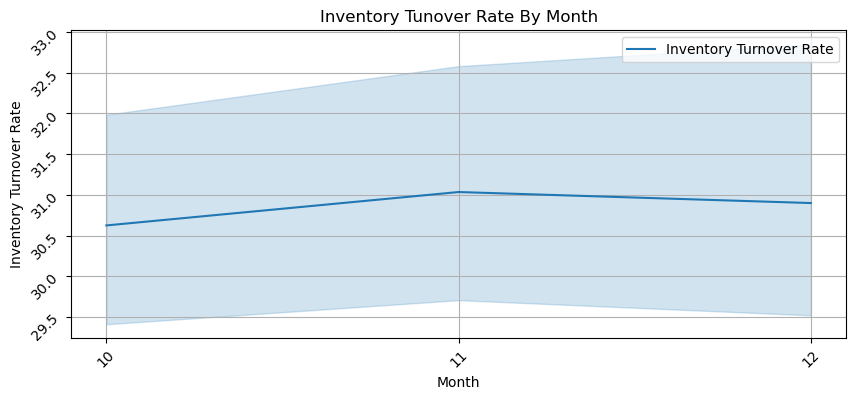

In [196]:
plt.figure(figsize=(10, 4))
sns.lineplot(x='Month', y='Inventory Turnover Rate', data=data, label='Inventory Turnover Rate')
plt.title("Inventory Tunover Rate By Month")
plt.xlabel("Month")
plt.ylabel("Inventory Turnover Rate")
plt.xticks(ticks = [10, 11, 12], rotation=45)
plt.yticks(rotation=45)
plt.grid()
plt.show()

Insights Drawn :

1. There was sudden increase of Inventory Turnover Rate in November
2. Then there was slight decrease of Inventory Turnover Rate in December

Conclusion :

1. The overall Inventory Turnover Rate trend suggest there was slight potential overstocking of products in December after coming from the fast moving good (FMG) phase from November.
2. This suggests the less demand of products and slight loss to the company by the end of the year

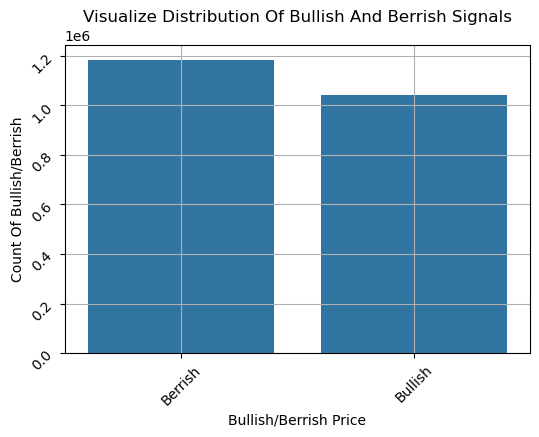

In [197]:
plt.figure(figsize = (6,4))
sns.countplot(data = data, x = 'Bullish/Berrish_Price')
plt.xlabel('Bullish/Berrish Price')
plt.ylabel('Count Of Bullish/Berrish')
plt.title('Visualize Distribution Of Bullish And Berrish Signals')
plt.grid()
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.show()

Insights Drawn :

There were more Berrish signals as compared to Bullish signals

Conclusion :

The Berrish/Bullish trend suggests there were less number of sales by the end of year throughout October to November emphasizing the need of optimal pricing strategies

(V) OVERALL CONCLUSION FROM EDA 

1. Though, after analyzing main features like Popularity Score, Market Share, Inventory Turnover Rate and Berrish/Bullish signals there were possibilities of loss by the end of year. 
2. But, upon analyzing price related features mainly Price, Competitor Price and Price Elasticity; there was a slight growth in market, competitive prices
3. Thus, by opting strategical price methods there are chances of improvising profitability by staying in competitive market

STEP - 5 : DEVELOPE TIME SERIES (ARIMA : Auto Regressive Integrated Moving Average) MODEL

5.1. PREPARE THE DATA

(A) STANDARDIZE THE DATA (MAKE STATASTICAL MEASURES LIKE MEAN AND VARIANCE CONSTANT {MEAN : 0 AND STD : 1})

In [199]:
# (A1) Compute Logarithmic Price Difference

# Load Data With All Prices Greater Then Zero
data = data[data['Price'] > 0]
# Compute Price Difference : Gives The Price Change Between Consecutive Days
data['Price_Diff'] = np.log(data['Price']) - np.log(data['Price'].shift(1))
# Clean Data : Drop NaN Values From Dataset
data = data.dropna(subset=['Price_Diff'])

In [200]:
# (A2) Do Z-Normalisation In Order To Standardize The Data (Make Mean : ~0 And STD : ~1)

# Standardize The Price Differences (Z-score normalization)
data['Price_Diff_Standardized'] = (data['Price_Diff'] - data['Price_Diff'].mean()) / data['Price_Diff'].std()

(B) ADD DATE FEATURE SINCE IT WAS NOT PRESENT INITIALLY

In [206]:
# Calculate Days And Add Date With Days, Months And Years Since Date Feature Is Not Present In Dataset
# Map Days To Month
days_in_month = {10: 31, 11: 30, 12: 31}
# Assign Day Based On Month Value
data['Day'] = data['Month'].map(days_in_month)
# Combine Year, Month And Day To Date Feature
data['Date'] = pd.to_datetime(data[['Year', 'Month', 'Day']])
# To Add Date Feature As First Feature Of Dataset
data.set_index('Date', inplace=True)
data.head(1)

,Product Name,Price,CategoryName,Brand Name,Competitor Price,Popularity Score,Price Elasticity,Inventory Turnover Rate,Market Share,Year,Month,MA_50_Price,MA_200_Price,Bullish/Berrish_Price,Price_Diff,Price_Diff_Standardized,Day
Date,,,,,,,,,,,,,,,,,
2023-12-31,"Echo Dot (5th generation, 2022 release) | Big ...",21.99,Hi-Fi Speakers,Echo,129.97202,71947.6,0.000306,696.134607,0.002371,2023,12,22.656667,22.656667,Berrish,-0.087049,-0.078885,31


(C) CHECK IF THE DATA IS STANDARDIZED

In [204]:
mean_diff_std = data['Price_Diff_Standardized'].mean()
std_diff_std = data['Price_Diff_Standardized'].std()

print(f'Mean : {mean_diff_std}, Standard Deviation : {std_diff_std}')

Mean : 1.3914583579386705e-17, Standard Deviation : 0.9999999999999828


Upon observing the results, we can see data has been standardized for the following reasons : 

1. Mean value is 1.3914583579386705e-17, which is closer to 0 due to the floating point precision limitations in computing
2. Standard Deviation value is 0.9999999999999828, which is closer to 1